# Anaylsis and Conclusions

Okay now we've moved a ton of data around, we've done layers and layers and layers of transformations. We've looked at distributions, and nulls, and distincts. We've painstakinlgy review model and hpyerparmater options. Now, let's look at our data! If you're running the full scripts you need to execute scripts 9-11 to get all content for your model versions. If you're not executing the scripts, sufficient sample data for all aggregations and visualizations below is already in the data folder and you're good to go.

Now let's see how our pipeline did!

Note: Depending on how you are accessing this notebook, it may look like some of the plots are plotted twice. This was intentional and to increase comapatiblity and readability for those accessing the notebooks from various formats. For all plots a dynamic and static visualization is rendered. You might see both.

#### Import statements

In [2]:
from IPython.display import Image
from IPython.display import display
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import random

## Final clustering output and segment data

The dataset we will be looking at contains all of the cluster outputs joined with information from the orignal segments. We will be doing a lot of visualizations, so we will be focusing on the trajectory data.

Some notes on the the trajectory data was tranformed:
- for this analysis we are looking at flight patterns, not any absolute flight locations
- all of the has been transformed to start at X, Y values of 0, 0
- all of the traces have been rotated to be oriented in the same direction, at the beginning of the trace
- the original x and y values of the traces is also in the dataframe
- all of this data can be joined with the orignal flight data
  - to do so, the segment_ids can be joined to the autoencoder_training_unscaled data, which will give you the icao and the start_timestamps
  - the first start_timestamp can be used to combine the data with the the orignal trace data

Non-deterministic nature of the data
- noth the pytorch auteoncoder and HDBSCAN are fundamentally non-deterministic, i.e. they will produce different results with the same data and hyperparametres
- as such, I will not be referring to cluster 1, cluster 2, etc. in the analysis below, but will only be reffering to the whole cluster set and the general relationships
- in production, both the autoencoder and HDBSCAN models can be tuned to be deterministic, or at least a lot more deterministic
  - I want to make this distiction to illustrate that reproducability and viability of these models in a production settings
  - for this exercise, allowing the models to be non-deterministic can be more insightful, as well as more performant as deterministic parameters can impede parelliation

### Output data sample and summary statistics

In [3]:
# read in and examine trajectories
trajectories = pd.read_parquet('../data/_11_analysis_conclusions/trajectories.parquet')

display(trajectories)

,segment_id,cluster,is_most_typical,is_most_extreme,icao,start_timestamp,point_idx,x,y,z,heading_deg,ground_speed,time_sec,original_x,original_y
0,8592900,5,False,False,152022,2024-08-01 19:20:37.080000+00:00,0,0.000000e+00,0.000000e+00,35000.0,90.90,557.10,0.00,0.00,0.00
1,8592900,5,False,False,152022,2024-08-01 19:20:37.080000+00:00,1,4.002771e-03,1.079390e+04,35000.0,91.10,556.10,19.41,10791.91,-207.22
2,8592900,5,False,False,152022,2024-08-01 19:20:37.080000+00:00,2,2.365087e-03,3.234834e+04,35000.0,91.10,556.10,38.76,32342.38,-621.01
3,8592900,5,False,False,152022,2024-08-01 19:20:37.080000+00:00,3,9.218618e-12,6.499697e+04,35000.0,91.10,556.10,58.71,64984.99,-1247.78
4,8592900,5,False,False,152022,2024-08-01 19:20:37.080000+00:00,4,-6.036192e-03,1.085113e+05,35000.0,91.10,555.10,78.39,108491.26,-2083.14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,11015141,-1,False,False,a7033d,2024-08-01 18:31:50.270000+00:00,45,4.355630e+03,1.800648e+06,5800.0,70.80,121.80,536.18,1750187.48,423316.22
499996,11015141,-1,False,False,a7033d,2024-08-01 18:31:50.270000+00:00,46,-1.368709e+03,1.866548e+06,5700.0,71.30,121.40,544.88,1812843.96,444524.27
499997,11015141,-1,False,False,a7033d,2024-08-01 18:31:50.270000+00:00,47,-5.630981e+03,1.933100e+06,5600.0,72.60,120.50,553.43,1876480.64,464466.80
499998,11015141,-1,False,False,a7033d,2024-08-01 18:31:50.270000+00:00,48,-9.959327e+03,2.000684e+06,5500.0,72.60,120.50,562.01,1941103.90,484718.50


In [3]:
# summary statistics for the trajectories data frame
spatial_stats = trajectories.groupby('cluster').agg({
    'x': ['mean', 'std', 'min', 'max'],
    'y': ['mean', 'std', 'min', 'max'],
    'z': ['mean', 'std', 'min', 'max']
}).round(2)

# Flatten column names
spatial_stats.columns = ['_'.join(col).strip() for col in spatial_stats.columns.values]
spatial_stats = spatial_stats.reset_index()

# Motion characteristics (heading, speed, time)
motion_stats = trajectories.groupby('cluster').agg({
    'heading_deg': ['mean', 'std', 'min', 'max'],
    'ground_speed': ['mean', 'std', 'min', 'max'],
    'time_sec': ['mean', 'std', 'min', 'max']
}).round(2)

# Flatten column names
motion_stats.columns = ['_'.join(col).strip() for col in motion_stats.columns.values]
motion_stats = motion_stats.reset_index()

# Add trajectory length to motion stats
motion_stats['points_count'] = trajectories.groupby('cluster').size()

print("Spatial Statistics:")
display(spatial_stats)
print("\nMotion Statistics:")
display(motion_stats)

Spatial Statistics:


,cluster,x_mean,x_std,x_min,x_max,y_mean,y_std,y_min,y_max,z_mean,z_std,z_min,z_max
0,-1,-1942.62,533814.04,-6717459.46,12629830.54,1521949.90,2072336.07,-4823197.26,22189403.48,19247.67,13737.59,-1000.0,58200.0
1,0,8843.95,80650.49,-468467.38,555004.72,31647.77,156065.26,-587418.28,984167.97,4504.97,6634.29,-100.0,34025.0
2,1,-59244.81,640210.80,-3562535.76,2903384.14,2322804.40,2527839.04,0.00,11141027.26,26835.10,12846.60,2050.0,41000.0
3,2,-73039.64,626636.35,-4037071.09,3102519.70,2171118.97,2242022.15,0.00,9127282.46,26599.65,10401.08,3050.0,40000.0
4,3,7714.21,514971.13,-5068829.93,5317957.21,1511620.73,1788109.60,0.00,9673329.79,14902.54,11959.37,525.0,41025.0
5,4,3830.38,325230.72,-4114201.75,4373344.20,730863.89,1073322.78,-1392557.67,8459709.05,9681.12,9349.23,-450.0,43025.0
6,5,89588.52,753026.27,-4021253.11,4145003.79,2233363.12,2336030.63,0.00,10761035.39,24393.29,13273.84,2775.0,41025.0
7,6,-5209.19,638942.82,-4520292.74,3618314.31,2360802.71,2513020.79,0.00,11077842.63,23021.67,12944.80,3800.0,42000.0
8,7,9993.61,723329.99,-3294048.08,3329559.35,2164033.37,2400001.73,0.00,10622578.52,22196.40,14664.34,-1000.0,45000.0
9,8,16506.16,581944.12,-2965890.61,3481347.98,2823557.58,2777870.71,0.00,11341303.74,29287.97,11035.01,1525.0,41050.0



Motion Statistics:


,cluster,heading_deg_mean,heading_deg_std,heading_deg_min,heading_deg_max,ground_speed_mean,ground_speed_std,ground_speed_min,ground_speed_max,time_sec_mean,time_sec_std,time_sec_min,time_sec_max,points_count
0,-1,176.099132,107.69,0.00,359.90,300.428502,154.07,0.70,1233.40,288.797756,222.04,-1880.48,2084.98,2550.0
1,0,190.460235,99.38,0.00,359.30,129.80051,92.21,0.70,451.40,63.9978,48.40,0.00,272.98,1750.0
2,1,151.394286,109.75,1.80,359.40,371.942857,146.13,86.00,561.10,394.042531,259.09,0.00,884.86,2300.0
3,2,176.158,98.19,3.30,359.30,377.07487,126.04,83.90,754.40,357.59003,225.88,0.00,826.08,5050.0
4,3,178.112931,103.72,0.00,359.60,247.070455,152.57,0.70,524.60,358.964624,203.71,0.00,847.88,140150.0
5,4,182.617651,101.74,0.00,360.00,210.861508,130.88,0.70,598.50,210.129712,149.79,0.00,1081.82,2800.0
6,5,175.908214,104.31,0.00,359.80,325.848036,152.62,60.20,571.50,402.946471,223.41,0.00,854.07,1750.0
7,6,180.735314,110.75,0.30,359.70,334.0052,159.36,103.70,575.50,411.750691,229.21,0.00,867.18,2050.0
8,7,170.834244,93.26,0.00,354.60,303.47361,164.00,0.70,529.60,422.477293,239.51,0.00,929.03,6900.0
9,8,198.011884,93.13,1.40,359.30,380.983913,129.79,99.30,545.50,435.603488,250.33,0.00,1392.83,88900.0


Look at the means particularly, we can definitely see some distinct variations between the clusters. But to really see the variations between cluseters, lets plot them.

## Flight traces visualizations

### Visualizing all clusters

Below we will look at a random set of 50 trajectories from each cluster.

X range: -6717459.4564295 to 12629830.54031996
Y range: -4823197.25611179 to 22189403.47771782
Z range: -1000.0 to 58200.0
Max range: 27012600.73382961
Center point: (2956185.54194523, 8683103.110803016, 28600.0)


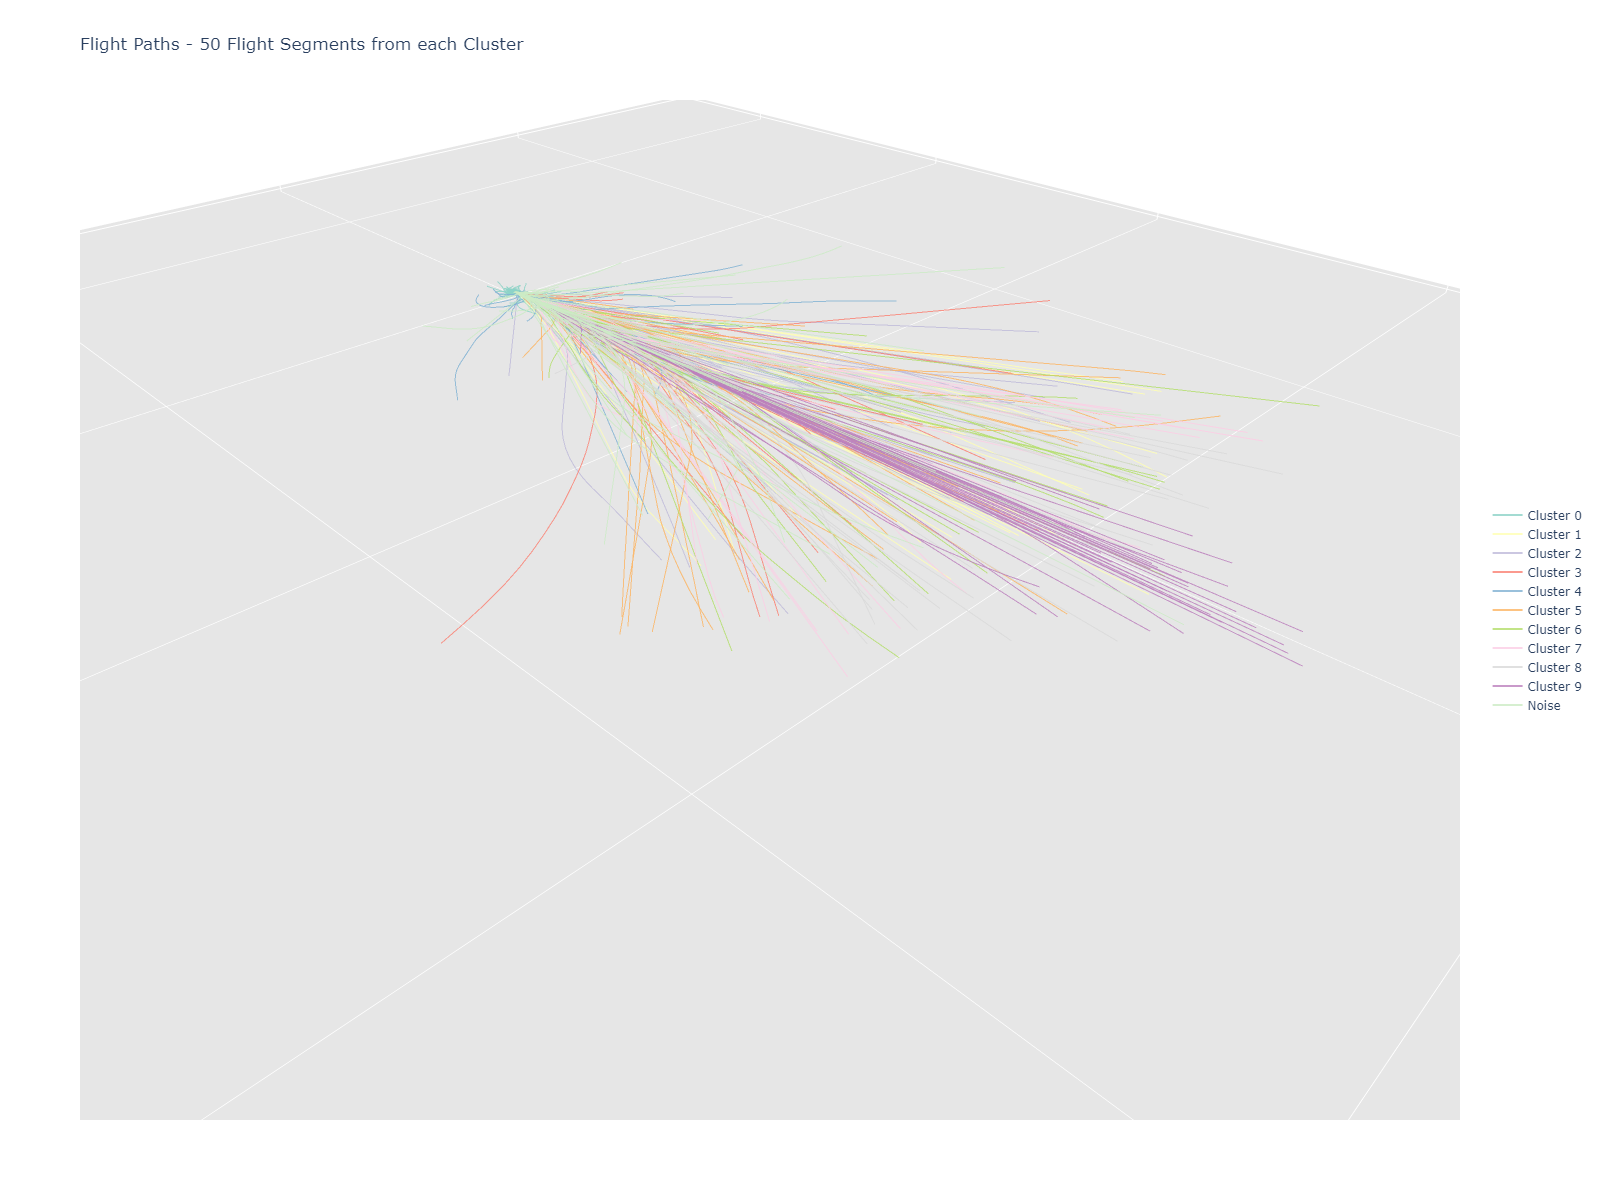

In [4]:
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import numpy as np
from IPython.display import Image

# Get all unique clusters and sort them so -1 is last
all_clusters = sorted(trajectories['cluster'].unique())
if -1 in all_clusters:
    all_clusters.remove(-1)
    all_clusters.append(-1)

# Create the 3D scatter plot
fig = go.Figure()

# Calculate overall ranges and print them for debugging
x_min, x_max = trajectories['x'].min(), trajectories['x'].max()
y_min, y_max = trajectories['y'].min(), trajectories['y'].max()
z_min, z_max = trajectories['z'].min(), trajectories['z'].max()

print(f"X range: {x_min} to {x_max}")
print(f"Y range: {y_min} to {y_max}")
print(f"Z range: {z_min} to {z_max}")

max_range = max(x_max - x_min, y_max - y_min, z_max - z_min)
print(f"Max range: {max_range}")

# Calculate center point of the data
center_x = (x_max + x_min) / 2
center_y = (y_max + y_min) / 2
center_z = (z_max + z_min) / 2

print(f"Center point: ({center_x}, {center_y}, {center_z})")

# Simpler camera positioning for testing
camera_distance = max_range * 1.5  # Start with a wider view for testing
camera_x = center_x + camera_distance
camera_y = center_y + camera_distance
camera_z = center_z + camera_distance

# Create a color sequence for each cluster
cluster_colors = px.colors.qualitative.Set3
# If we need more colors than available in the palette, we'll cycle through them
cluster_colors = cluster_colors * (len(all_clusters) // len(cluster_colors) + 1)

# Track total segments for title
total_segments = 0

# Process each cluster
for cluster_idx, cluster in enumerate(all_clusters):
    # Filter for current cluster
    cluster_data = trajectories[trajectories['cluster'] == cluster]
    
    # Convert decimal columns to float if needed
    numeric_columns = ['x', 'y', 'z']
    for col in numeric_columns:
        if cluster_data[col].dtype == 'object':
            cluster_data[col] = cluster_data[col].astype(float)
    
    # Get unique segment IDs for current cluster
    unique_segments = cluster_data['segment_id'].unique()
    
    # Get random sample of up to 50 segment IDs
    n_segments = min(50, len(unique_segments))
    selected_segments = np.random.choice(unique_segments, size=n_segments, replace=False)
    total_segments += n_segments
    
    cluster_name = 'Noise' if cluster == -1 else f'Cluster {cluster}'
    
    # Add each trajectory as a separate trace
    for idx, segment_id in enumerate(selected_segments):
        segment_data = cluster_data[cluster_data['segment_id'] == segment_id]
        
        fig.add_trace(go.Scatter3d(
            x=segment_data['x'],
            y=segment_data['y'],
            z=segment_data['z'],
            mode='lines',
            line=dict(
                width=2,
                color=cluster_colors[cluster_idx]
            ),
            opacity=0.8,
            name=cluster_name,
            showlegend=(idx == 0)  # Only show legend entry once per cluster
        ))

# Update layout for better visualization
fig.update_layout(
    title=f'Flight Paths - 50 Flight Segments from each Cluster',
    scene=dict(
        camera=dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),  # Center at origin for testing
            eye=dict(x=1.5, y=1.5, z=1.5)  # Simple isometric view
        ),
        aspectmode='data',  # Let Plotly determine the best aspect ratio based on data
        xaxis=dict(
            title='X',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            range=[float(x_min - max_range*0.1), float(x_max + max_range*0.1)]
        ),
        yaxis=dict(
            title='Y',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            range=[float(y_min - max_range*0.1), float(y_max + max_range*0.1)]
        ),
        zaxis=dict(
            title='Z',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            range=[float(z_min - max_range*0.1), float(z_max + max_range*0.1)],
            nticks=1
        )
    ),
    width=1600,
    height=1200,
    showlegend=True,
    legend=dict(yanchor="middle", y=0.5)
)

# Display interactive plot
#fig.show()

# Save static version
pio.write_image(fig, "all_clusters_paths.png")

Image("all_clusters_paths.png")

Now this plot is a little noisy, but we can already start to detect some clear patterns. One of which, is that it looks like there is hardly any altitude movement whatsoever. This is not an error, but in fact of represenation of how much greater the x and y coordinate movement is in relation to the altitude chagnes. In the fraph above all 3 dimensions are scaled identically. However, to better asses our pattern recognition success, let's look unscale the Z-axis.

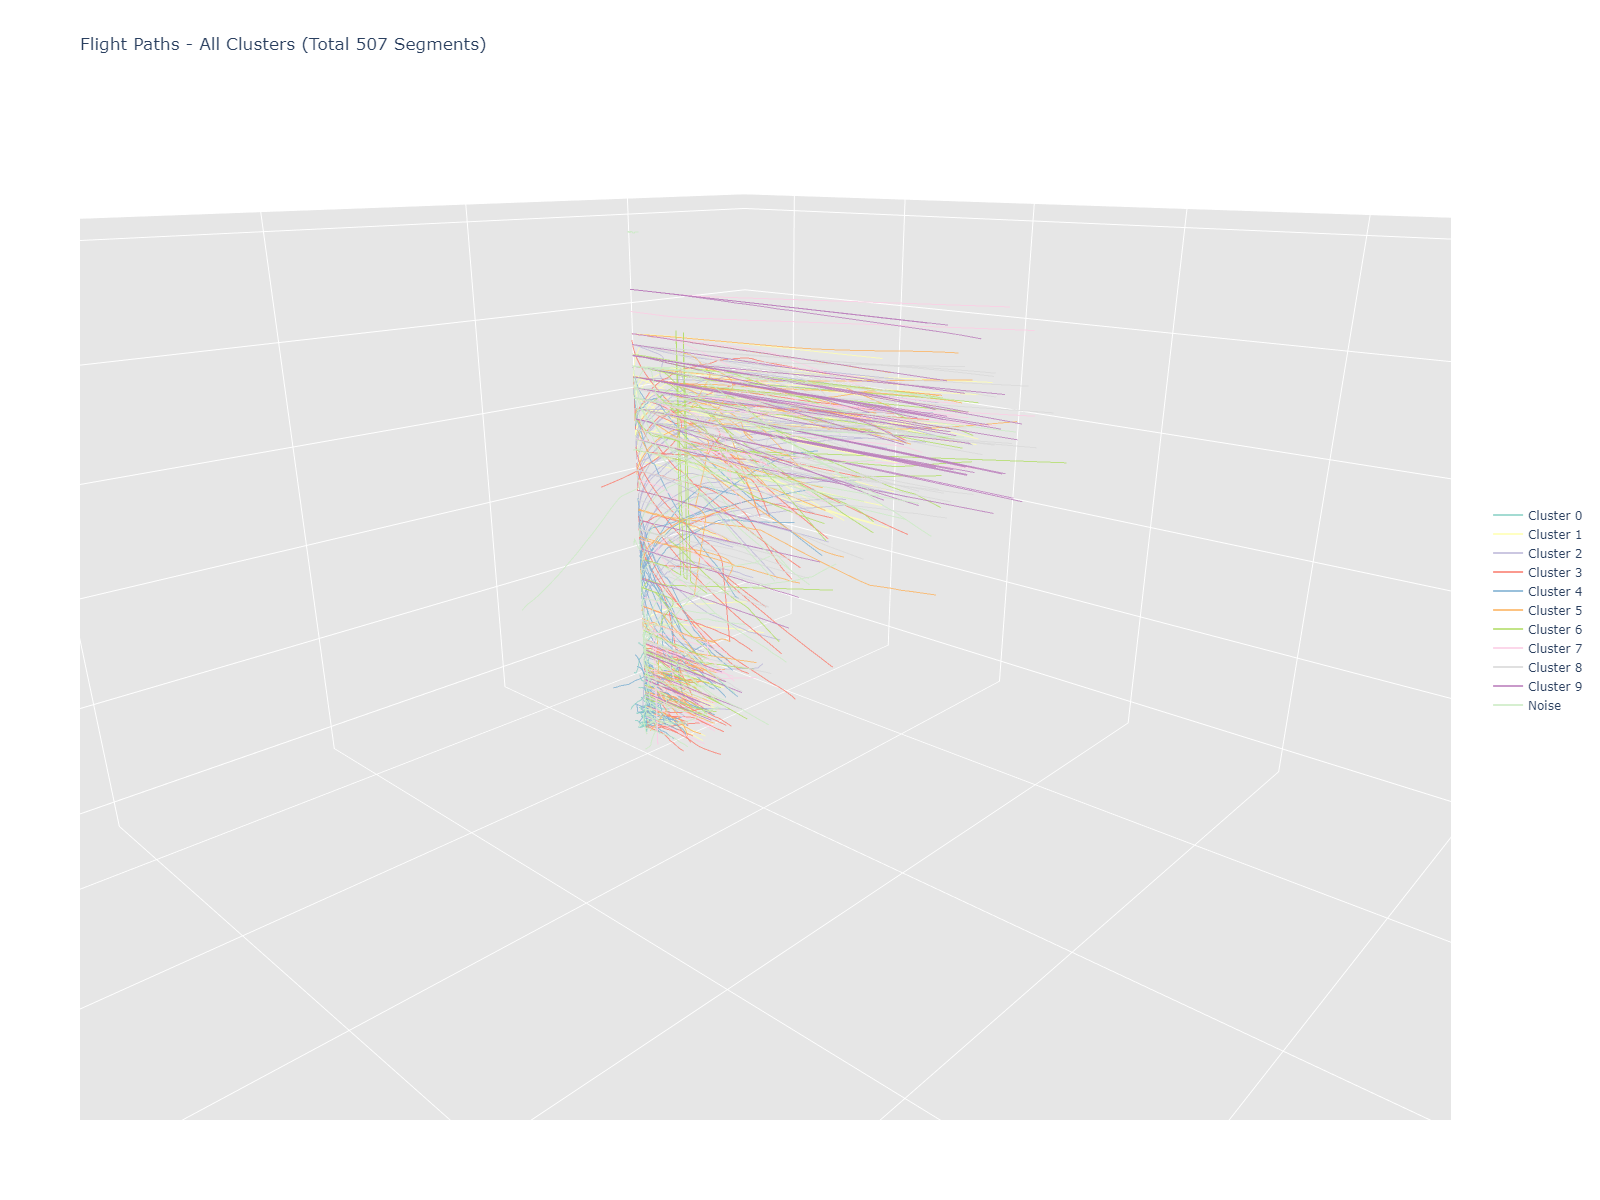

In [5]:
# Get all unique clusters and sort them so -1 is last
all_clusters = sorted(trajectories['cluster'].unique())
if -1 in all_clusters:
    all_clusters.remove(-1)
    all_clusters.append(-1)

# Create the 3D scatter plot
fig = go.Figure()

# Calculate overall ranges for consistent scaling across all clusters
x_min, x_max = trajectories['x'].min(), trajectories['x'].max()
y_min, y_max = trajectories['y'].min(), trajectories['y'].max()
z_min, z_max = trajectories['z'].min(), trajectories['z'].max()
max_range = max(x_max - x_min, y_max - y_min, z_max - z_min)

# Create a color sequence for each cluster
cluster_colors = px.colors.qualitative.Set3
# If we need more colors than available in the palette, we'll cycle through them
cluster_colors = cluster_colors * (len(all_clusters) // len(cluster_colors) + 1)

# Track total segments for title
total_segments = 0

# Process each cluster
for cluster_idx, cluster in enumerate(all_clusters):
    # Filter for current cluster
    cluster_data = trajectories[trajectories['cluster'] == cluster]
    
    # Convert decimal columns to float if needed
    numeric_columns = ['x', 'y', 'z']
    for col in numeric_columns:
        if cluster_data[col].dtype == 'object':
            cluster_data[col] = cluster_data[col].astype(float)
    
    # Get unique segment IDs for current cluster
    unique_segments = cluster_data['segment_id'].unique()
    
    # Get random sample of up to 50 segment IDs
    n_segments = min(50, len(unique_segments))
    selected_segments = np.random.choice(unique_segments, size=n_segments, replace=False)
    total_segments += n_segments
    
    cluster_name = 'Noise' if cluster == -1 else f'Cluster {cluster}'
    
    # Add each trajectory as a separate trace
    for idx, segment_id in enumerate(selected_segments):
        segment_data = cluster_data[cluster_data['segment_id'] == segment_id]
        
        fig.add_trace(go.Scatter3d(
            x=segment_data['x'],
            y=segment_data['y'],
            z=segment_data['z'],
            mode='lines',
            line=dict(
                width=2,
                color=cluster_colors[cluster_idx]
            ),
            opacity=0.8,
            name=cluster_name,
            showlegend=(idx == 0)  # Only show legend entry once per cluster
        ))

# Update layout for better visualization
fig.update_layout(
    title=f'Flight Paths - All Clusters (Total {total_segments} Segments)',
    scene=dict(
        camera=dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            # Modified camera position:
            # - Reduced distance (zoomed in) by reducing all values
            # - Rotated ~43 degrees counterclockwise by adjusting x/y ratio
            eye=dict(
                x=0.8 * np.cos(np.radians(43)),  # Apply rotation
                y=0.8 * np.sin(np.radians(43)),  # Apply rotation
                z=0.3  # Reduced for closer zoom
            )
        ),
        aspectmode='manual',
        aspectratio=dict(
            x=1, 
            y=1, 
            z=0.5
        ),
        xaxis=dict(
            title='X',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            range=[float(x_min - max_range*0.1), float(x_max + max_range*0.1)]
        ),
        yaxis=dict(
            title='Y',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)',
            range=[float(y_min - max_range*0.1), float(y_max + max_range*0.1)]
        ),
        zaxis=dict(
            title='Z',
            showbackground=True,
            backgroundcolor='rgb(230, 230,230)'
        )
    ),
    width=1600,
    height=1200,
    showlegend=True,
    legend=dict(
        yanchor="middle", 
        y=0.5,
        xanchor="right",
        x=1.1
    )
)

# Display interactive plot
fig.show()

# Save static version
pio.write_image(fig, "all_clusters_paths_z_unscaled.png")

Image("all_clusters_paths_z_unscaled.png")

Now we can see some very clear patterns start to emerge and our clusters begin to make sense. Not that the last trace is the noise category, and thus will contain many outliers. Now that we've gotten a decenct view of all the clusters, lets look at our clusters individually to get higher degree of granularity.

### Individual cluster visualizations

We are going to do 2 plots for each of the clusters. The first contains 2 select traces from each cluster calculated with _10_clustering.py. They are:

The most "average" or "representative" trace within a cluster, determined by:
- Calculating the average distance from each point to all other points in the cluster
- Finding the point that has the smallest average distance to everything else
- You can think of this as finding the most "central" point in the cluster

And the most extreme trace within each cluster, determined by:
- Calculating the average distance from each point to all other points (same as above)
- Finding the point that has the largest average distance to everything else
- This identifies the point that's most "far away" from the rest of the cluster

The second plot will be simliar to the above, but only showing 50 random traces from the cluster we are currently analyzing.

Note: All plots below will have the z-axis auto-scaled, i.e. the x and y point distance will be equivalent to each other, but changes in the Z axis will actually be much greater than their real magnitude.

In [7]:
# Filter for Cluster 1, excluding typical and extreme traces
other_traces = trajectories[
    (trajectories['cluster'] == 8) & 
    (trajectories['is_most_typical'] == False) &
    (trajectories['is_most_extreme'] == False)
]

# Get unique segment IDs
unique_segments = other_traces['segment_id'].unique()

# Use all available segments except typical and extreme
selected_segment_ids = unique_segments

# Get typical and extreme traces for cluster 1
typical_trace = trajectories[
    (trajectories['cluster'] == 1) & 
    (trajectories['is_most_typical'] == True)
]

extreme_trace = trajectories[
    (trajectories['cluster'] == 1) & 
    (trajectories['is_most_extreme'] == True)
]

# Create the 3D scatter plot
fig = go.Figure()

# Add the random traces first
for segment_id in selected_segment_ids:
    trace_data = other_traces[other_traces['segment_id'] == segment_id]
    fig.add_trace(go.Scatter3d(
        x=trace_data['x'],
        y=trace_data['y'],
        z=trace_data['z'],
        mode='lines',
        name='Random Trace',
        line=dict(
            width=1,
            color='rgba(99, 99, 59, 0.6)'
        ),
        showlegend=bool(segment_id == selected_segment_ids[0])
    ))

# Add typical trace path
fig.add_trace(go.Scatter3d(
    x=typical_trace['x'],
    y=typical_trace['y'],
    z=typical_trace['z'],
    mode='lines+markers',
    name='Typical Path',
    line=dict(
        width=2,
        color='rgba(255, 182, 193, 1)'
    ),
    marker=dict(
        size=2,
        color='rgba(255, 182, 193, 1)',
        opacity=0.8
    )
))

# Add extreme trace path
fig.add_trace(go.Scatter3d(
    x=extreme_trace['x'],
    y=extreme_trace['y'],
    z=extreme_trace['z'],
    mode='lines+markers',
    name='Extreme Path',
    line=dict(
        width=2,
        color='rgba(173, 216, 230, 1)'
    ),
    marker=dict(
        size=2,
        color='rgba(173, 216, 230, 1)',
        opacity=0.8
    )
))

# Add start and end points for typical trace
fig.add_trace(go.Scatter3d(
    x=[typical_trace['x'].iloc[0]],
    y=[typical_trace['y'].iloc[0]],
    z=[typical_trace['z'].iloc[0]],
    mode='markers',
    name='Start Point',
    marker=dict(
        size=8,
        symbol='diamond',
        color='rgba(50, 205, 50, 1)',
        opacity=1
    )
))

fig.add_trace(go.Scatter3d(
    x=[typical_trace['x'].iloc[49]],
    y=[typical_trace['y'].iloc[49]],
    z=[typical_trace['z'].iloc[49]],
    mode='markers',
    name='End Point',
    marker=dict(
        size=8,
        symbol='cross',
        color='rgba(255, 99, 71, 1)',
        opacity=1
    )
))

# Add start and end points for extreme trace
fig.add_trace(go.Scatter3d(
    x=[extreme_trace['x'].iloc[0]],
    y=[extreme_trace['y'].iloc[0]],
    z=[extreme_trace['z'].iloc[0]],
    mode='markers',
    showlegend=False,
    marker=dict(
        size=8,
        symbol='diamond',
        color='rgba(50, 205, 50, 1)',
        opacity=1
    )
))

fig.add_trace(go.Scatter3d(
    x=[extreme_trace['x'].iloc[49]],
    y=[extreme_trace['y'].iloc[49]],
    z=[extreme_trace['z'].iloc[49]],
    mode='markers',
    showlegend=False,
    marker=dict(
        size=8,
        symbol='cross',
        color='rgba(255, 99, 71, 1)',
        opacity=1
    )
))

# Update layout
fig.update_layout(
    title=f'Flight Paths - Cluster 1 (Typical, Extreme, and {len(selected_segment_ids)} Random Traces)',
    scene=dict(
        camera=dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=1.5, y=1.5, z=1.5)
        ),
        aspectmode='cube',
        xaxis=dict(
            title='X',
            showbackground=True,
            backgroundcolor='rgb(230, 230, 230)'
        ),
        yaxis=dict(
            title='Y',
            showbackground=True,
            backgroundcolor='rgb(230, 230, 230)'
        ),
        zaxis=dict(
            title='Z',
            showbackground=True,
            backgroundcolor='rgb(230, 230, 230)'
        )
    ),
    width=1600,
    height=1200,
    showlegend=True,
    legend=dict(
        yanchor="middle", 
        y=0.5,
        xanchor="right",
        x=1.1
    )
)

# Display and save
fig.show()
pio.write_image(fig, "flight_path_comparison.png")

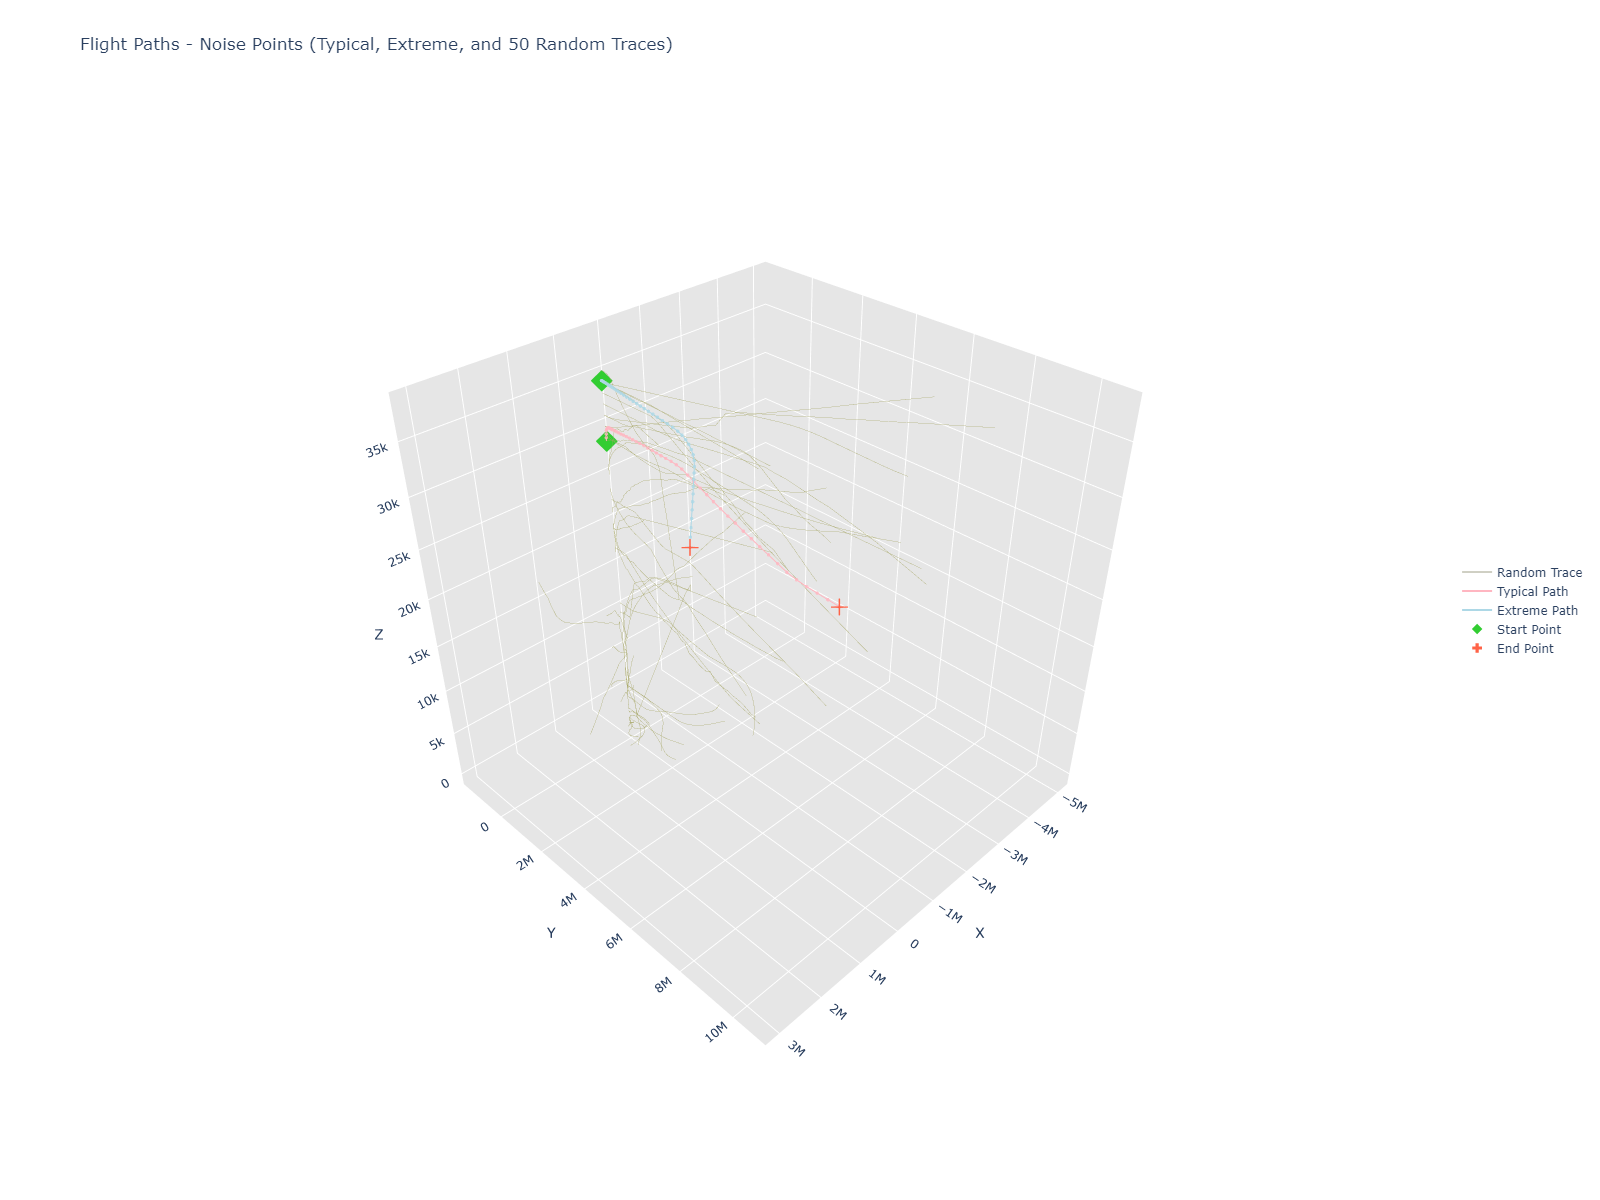

In [8]:
# Filter for Cluster 1, excluding typical and extreme traces
other_traces = trajectories[
    (trajectories['cluster'] == -1) & 
    (trajectories['is_most_typical'] == False) &
    (trajectories['is_most_extreme'] == False)
]

# Get unique segment IDs
unique_segments = other_traces['segment_id'].unique()

# Randomly select 50 segments
# If there are fewer than 50 segments, it will take all available ones
selected_segment_ids = np.random.choice(
    unique_segments, 
    size=min(50, len(unique_segments)), 
    replace=False  # This ensures no duplicate segments are selected
)

# Get typical and extreme traces for cluster 1
typical_trace = trajectories[
    (trajectories['cluster'] == 1) & 
    (trajectories['is_most_typical'] == True)
]

extreme_trace = trajectories[
    (trajectories['cluster'] == 1) & 
    (trajectories['is_most_extreme'] == True)
]

# Create the 3D scatter plot
fig = go.Figure()

# Add the random traces first
for segment_id in selected_segment_ids:
    trace_data = other_traces[other_traces['segment_id'] == segment_id]
    fig.add_trace(go.Scatter3d(
        x=trace_data['x'],
        y=trace_data['y'],
        z=trace_data['z'],
        mode='lines',
        name='Random Trace',
        line=dict(
            width=1,
            color='rgba(99, 99, 59, 0.6)'
        ),
        showlegend=bool(segment_id == selected_segment_ids[0])
    ))

# Add typical trace path
fig.add_trace(go.Scatter3d(
    x=typical_trace['x'],
    y=typical_trace['y'],
    z=typical_trace['z'],
    mode='lines+markers',
    name='Typical Path',
    line=dict(
        width=2,
        color='rgba(255, 182, 193, 1)'
    ),
    marker=dict(
        size=2,
        color='rgba(255, 182, 193, 1)',
        opacity=0.8
    )
))

# Add extreme trace path
fig.add_trace(go.Scatter3d(
    x=extreme_trace['x'],
    y=extreme_trace['y'],
    z=extreme_trace['z'],
    mode='lines+markers',
    name='Extreme Path',
    line=dict(
        width=2,
        color='rgba(173, 216, 230, 1)'
    ),
    marker=dict(
        size=2,
        color='rgba(173, 216, 230, 1)',
        opacity=0.8
    )
))

# Add start and end points for typical trace
fig.add_trace(go.Scatter3d(
    x=[typical_trace['x'].iloc[0]],
    y=[typical_trace['y'].iloc[0]],
    z=[typical_trace['z'].iloc[0]],
    mode='markers',
    name='Start Point',
    marker=dict(
        size=8,
        symbol='diamond',
        color='rgba(50, 205, 50, 1)',
        opacity=1
    )
))

fig.add_trace(go.Scatter3d(
    x=[typical_trace['x'].iloc[49]],
    y=[typical_trace['y'].iloc[49]],
    z=[typical_trace['z'].iloc[49]],
    mode='markers',
    name='End Point',
    marker=dict(
        size=8,
        symbol='cross',
        color='rgba(255, 99, 71, 1)',
        opacity=1
    )
))

# Add start and end points for extreme trace
fig.add_trace(go.Scatter3d(
    x=[extreme_trace['x'].iloc[0]],
    y=[extreme_trace['y'].iloc[0]],
    z=[extreme_trace['z'].iloc[0]],
    mode='markers',
    showlegend=False,
    marker=dict(
        size=8,
        symbol='diamond',
        color='rgba(50, 205, 50, 1)',
        opacity=1
    )
))

fig.add_trace(go.Scatter3d(
    x=[extreme_trace['x'].iloc[49]],
    y=[extreme_trace['y'].iloc[49]],
    z=[extreme_trace['z'].iloc[49]],
    mode='markers',
    showlegend=False,
    marker=dict(
        size=8,
        symbol='cross',
        color='rgba(255, 99, 71, 1)',
        opacity=1
    )
))

# Update layout
fig.update_layout(
    title=f'Flight Paths - Noise Points (Typical, Extreme, and {len(selected_segment_ids)} Random Traces)',
    scene=dict(
        camera=dict(
            up=dict(x=0, y=0, z=1),
            center=dict(x=0, y=0, z=0),
            eye=dict(x=1.5, y=1.5, z=1.5)
        ),
        aspectmode='cube',
        xaxis=dict(
            title='X',
            showbackground=True,
            backgroundcolor='rgb(230, 230, 230)'
        ),
        yaxis=dict(
            title='Y',
            showbackground=True,
            backgroundcolor='rgb(230, 230, 230)'
        ),
        zaxis=dict(
            title='Z',
            showbackground=True,
            backgroundcolor='rgb(230, 230, 230)'
        )
    ),
    width=1600,
    height=1200,
    showlegend=True,
    legend=dict(
        yanchor="middle", 
        y=0.5,
        xanchor="right",
        x=1.1
    )
)

# Display and save
fig.show()
pio.write_image(fig, "noise_path_comparison.png")
Image("noise_path_comparison.png")

### Future work

There is a ton of other fun things I could think to try on with this data set. I'll go over them below.

#### Other potential models to try

I think it would be interesting to try

#### Feature engineering

### Notes on optimization for production

#### Accounting for the scale of that data

Even just 1 full day of flight traces was starting to get to be too much for my PostgreSQL server. In the cloud, you could scale up the PostgrSQL to have significantly more resources, which would work for a while. There are also techniques like table partitioning and materialized views that would help with some use cases. But if I had a client that really wanted to analyze this much data on a regular basis, you would eventually have to move to something distributed. My favorite disributed data warehouse is Snowflake, but Redshift or BigQuery would be just as good.

For accounting for the scale of the data with regard to the ML models, the first thing I would need to change is finishing GPU acceleration support for HDBSCAN. Afte that, there is probably a lot of memory optimization I could do without sacrificing much model performance. I could look at the precision of all data points and see what the impact was on reducing it. I could also implement packages like Accelerate and Bitsandbytes to optimize memory usage. Also, I coudl implement the code in Tensorflow instead of pytorch, which in my expereince generally has better performance overall. 

Eventually though, as with the database, at a certain point the only option we be going distributed. There are now multiple pretty good cloud tools for creating distributed models; the first that comes to mind is Sagemaker. But what what I would do is just go with distribution the load into multiple nodes using kubernetes. Both pytorch and tensorflow support this method distributed computing, and combining it with kubernetes give you a deployment route that is highly configurable and transparent, and that will mesh with the infrastructure of most modern stacks.

#### Running the data processing in production

I actually think the code I built to run the batch jobs to ingest the data is pretty decent. On a small enough scale, I would probably use it in produciton, but 